# Chronos - Basic Usage

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
my_ts_data.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [ ]:
from chronos import Chronos

In [ ]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.001,
                     distribution="StudentT", 
                     seasonality_mode="add")
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=365)

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
my_chronos.plot_components(predictions);

## COVID

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [2]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,35,Ontario,Ontario,2020-01-31,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,British Columbia,Colombie-Britannique,2020-01-31,1,0,0.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
canada_mask = covid_data['prname'] == 'Canada'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

,date,numtoday
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


In [4]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid = canada_daily_covid[canada_daily_covid['y']> 0]
canada_daily_covid.head()


,ds,y
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


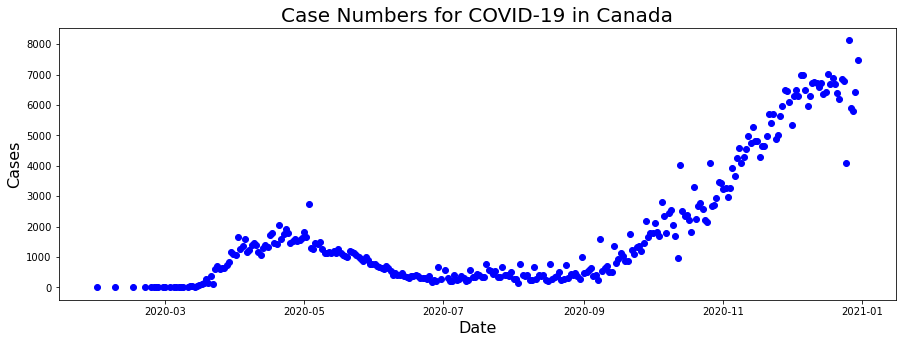

In [5]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [6]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.001, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=1.0,
                     distribution="Gamma",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.987                                                                          


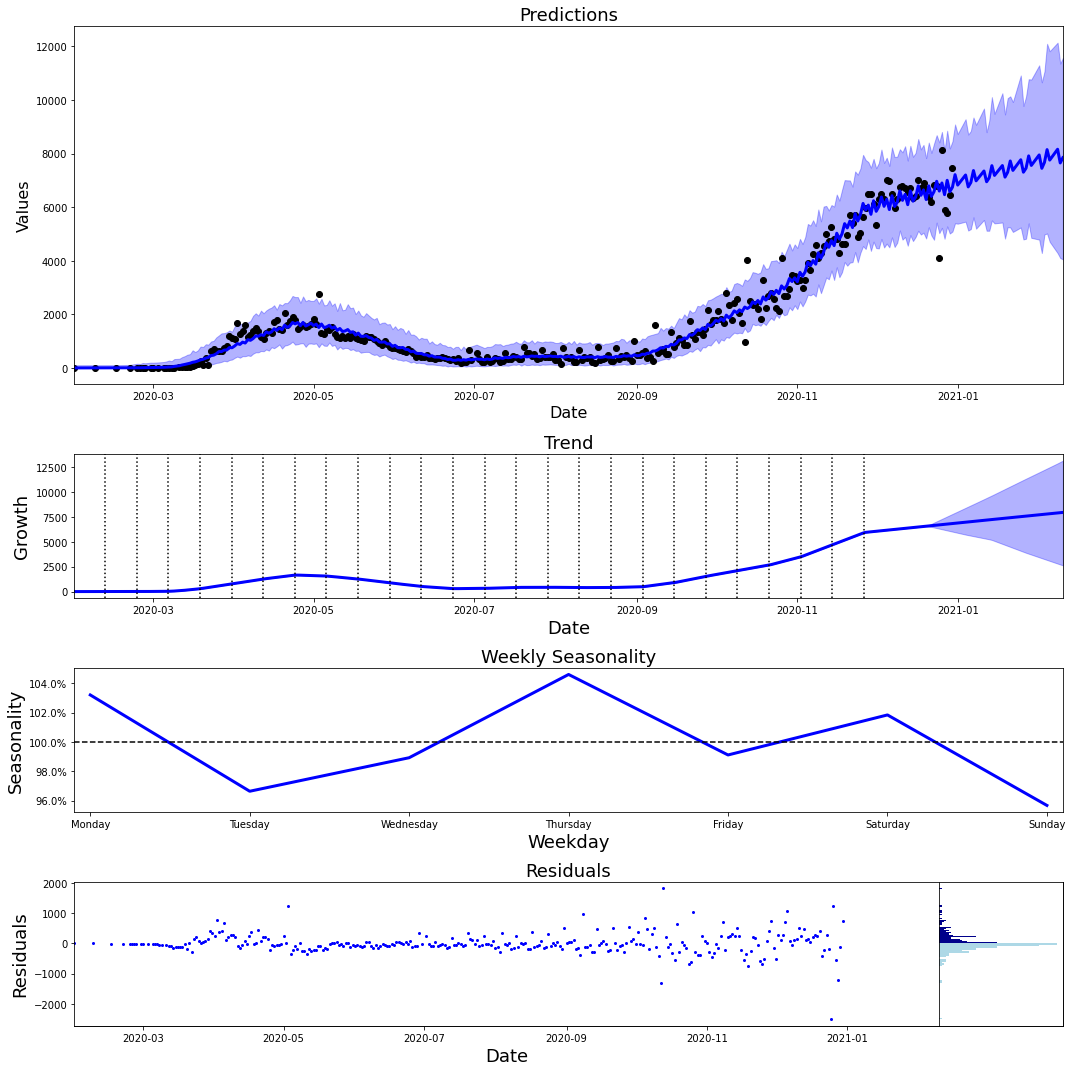

In [7]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.99)
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

In [ ]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
MAE = round(np.mean(np.abs(predictions['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(predictions['ds'], predictions['yhat'], c="green")
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(predictions['ds'], predictions['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada.\nMAE={MAE}", size=20)
plt.show()

In [ ]:
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.0001, 
                     n_changepoints=25,
                     seasonality_mode="add",
                     distribution="Gamma",
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020\nMAE={MAE}", size=20)
plt.show()

In [ ]:
my_chronos.plot_components(predictions, figure_name="AAPL.png", changepoint_threshold=0.3);